# Denoising of Text Images

Dataset used: [Denoising Dirty Documents](https://www.kaggle.com/competitions/denoising-dirty-documents/data)

### Settings

In [1]:
TRAIN_X_FOLDER = "dataset/train"
TRAIN_Y_FOLDER = "dataset/train_cleaned"

TRAIN_X = "dataset/train.csv"
TRAIN_Y = "dataset/label.csv"

MODEL_PATH = "_models/Denoiser.jl"

In [2]:
from typing import TYPE_CHECKING
from glob import glob

import cv2
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib as jl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

if TYPE_CHECKING:
    from numpy import ndarray

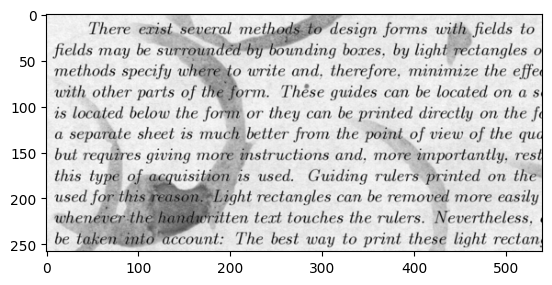

In [3]:
# This image will be used for demonstration in notebook
X_img = cv2.imread(f"{TRAIN_X_FOLDER}/2.png", cv2.IMREAD_GRAYSCALE)
Y_img = cv2.imread(f"{TRAIN_Y_FOLDER}/2.png", cv2.IMREAD_GRAYSCALE) / 255.

plt.imshow(X_img, "gray")

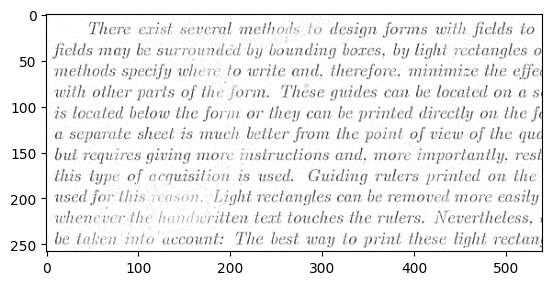

In [4]:
def blur_and_threshold(image: 'ndarray', eps=1e-7):
    """This function removes unnecessary artifacts from image and makes the
    foreground pop.
    
    It achieves this by subtracting the blurred image from the original image.
    Also scales image pixels in range [0, 1]."""
    blur = cv2.medianBlur(image, 5)
    foreground = image.astype('float') - blur
    foreground[foreground > 0] = 0
    minVal = np.min(foreground)
    maxVal = np.max(foreground)
    
    # Scaling image to range [0, 1]
    foreground = (foreground - minVal) / (maxVal - minVal + eps)
    return foreground

bnt = blur_and_threshold(X_img)
plt.imshow(bnt, "gray")

# Feature Extraction

We will flatten all 5x5 regions of the image and then use them as input features to our model.  
Our model will predict the value of the center pixel in the same 5x5 region of cleaned image.

In [5]:
def extract_features(X_img: 'ndarray', Y_img: 'ndarray',
                     samples: int=2000, seed=None):
    """X_img and Y_img should be scaled to [0, 1]"""
    
    size_x, size_y = X_img.shape
    n = size_x * size_y
    
    X_img = cv2.copyMakeBorder(X_img, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
    Y_img = cv2.copyMakeBorder(Y_img, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
    
    X_out = np.full([n, 25], -1.)
    Y_out = np.full([n], -1.)
    
    for x in range(X_img.shape[0]-4):
        for y in range(X_img.shape[1]-4):
            X_slice = X_img[x:x+5, y:y+5].flatten()
            Y_slice = Y_img[x+2, y+2]
            
            assert X_slice.shape[0] == 25, \
                f"{(x, y)}: X_slice is of {X_slice.shape[0]} size, instead of 25"
            
            X_out[x*size_y+y] = X_slice
            Y_out[x*size_y+y] = Y_slice
            
    gen = np.random.default_rng(seed)
    selection = gen.integers(n, size=(samples))
    X_out = X_out[selection].copy()
    Y_out = Y_out[selection].copy()
    
    return X_out, Y_out
            
X, Y = extract_features(bnt, Y_img)
print(f"Features: {X}")
print("Shape:", X.shape)
print(f"\nLabels: {Y}")
print("Shape:", Y.shape)

Features: [[0.46636771 1.         1.         ... 1.         1.         1.        ]
 [0.18834081 0.83856502 1.         ... 1.         0.46188341 0.3632287 ]
 [0.32286996 0.88789238 1.         ... 1.         1.         0.99551569]
 ...
 [1.         1.         1.         ... 0.98654708 1.         1.        ]
 [1.         0.7264574  0.69058296 ... 0.38116592 1.         1.        ]
 [0.98654708 0.99103139 1.         ... 0.95515695 0.30941704 0.44394619]]
Shape: (2000, 25)

Labels: [0.43529412 0.99607843 0.99607843 ... 1.         0.00784314 1.        ]
Shape: (2000,)


In [6]:
def data2csv(train_img_paths: list[str], label_img_paths: list[str], 
             train_save_path: str, label_save_path: str):
    
        X_data = Y_data = None
        for i, (X_path, Y_path) in \
                tqdm(enumerate(zip(train_img_paths, label_img_paths)), 
                     total= len(train_img_paths)):
                
                X_img = cv2.imread(X_path, cv2.IMREAD_GRAYSCALE)
                X_img = blur_and_threshold(X_img)
                Y_img = cv2.imread(Y_path, cv2.IMREAD_GRAYSCALE) / 255.

                X, Y = extract_features(X_img, Y_img)
                
                if X_data is None:
                        samples = len(train_img_paths)*X.shape[0]
                        X_data = np.full([samples, 25], -1.)
                        Y_data = np.full([samples], -1.)
                        samples = X.shape[0]
                        
                i *= samples
                X_data[i:i+samples] = X
                Y_data[i:i+samples] = Y
        
        np.savetxt(train_save_path, X_data, delimiter=",")
        np.savetxt(label_save_path, Y_data, delimiter=",")
        return X_data, Y_data
    

X_paths = glob(f"{TRAIN_X_FOLDER}/*.png")
Y_paths = glob(f"{TRAIN_Y_FOLDER}/*.png")
print(f"Train images: {len(X_paths)}, Label images: {len(Y_paths)}")

X, Y = data2csv(X_paths, Y_paths, TRAIN_X, TRAIN_Y)
print(f"Dataset created!! (Size= {X.shape[0]})")

Train images: 144, Label images: 144


  0%|          | 0/144 [00:00<?, ?it/s]

Dataset created!! (Size= 288000)


### Loading Dataset

In [7]:
X = np.loadtxt(TRAIN_X, delimiter=",")
Y = np.loadtxt(TRAIN_Y, delimiter=",")
print(f"Trainset sample: {X[0]}")
print(f"\nTrainset shape: {X.shape}")
print(f"\nLabel sample: {Y[0]}")
print(f"\nLabels shape: {Y.shape}")

Trainset sample: [0.98222222 0.99555556 1.         0.99111111 0.98222222 1.
 1.         1.         1.         0.99555556 1.         0.99111111
 1.         0.99555556 1.         1.         1.         1.
 1.         1.         0.99111111 0.99555556 1.         0.98666667
 1.        ]

Trainset shape: (288000, 25)

Label sample: 1.0

Labels shape: (288000,)


# Creating the prediction model

In [8]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=42)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(259200, 25) (259200,) (28800, 25) (28800,)


In [9]:
model = RandomForestRegressor(10)
print("Training the model...")
model.fit(trainX, trainY)

preds = model.predict(testX)
rmse = np.sqrt(mean_squared_error(testY, preds))
print(f"RMSE on test data: {rmse}")

Training the model...
RMSE on test data: 0.053959504686729026


### Saving Model

In [10]:
jl.dump(model, MODEL_PATH)

['_models/Denoiser.jl']

## Image Prediction

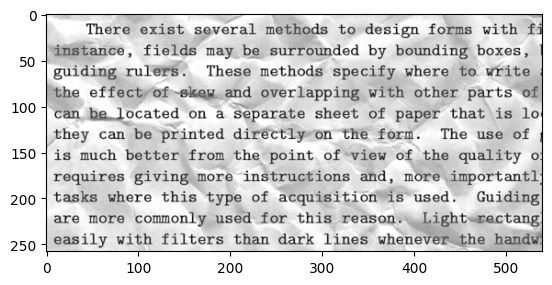

In [11]:
# This image will be used for demonstration in notebook
Xtest_img = cv2.imread(f"{TRAIN_X_FOLDER}/71.png", cv2.IMREAD_GRAYSCALE)
Ytest_img = cv2.imread(f"{TRAIN_Y_FOLDER}/71.png", cv2.IMREAD_GRAYSCALE) / 255.
model = jl.load(MODEL_PATH)

plt.imshow(Xtest_img, "gray")

In [12]:
def blur_extract_features(img: 'ndarray'):
    """X_img and Y_img should be scaled to [0, 1]"""
    
    img = blur_and_threshold(img)
    
    size_x, size_y = img.shape
    n = size_x * size_y
    
    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
    
    out = np.full([n, 25], -1.)
    
    for x in range(img.shape[0]-4):
        for y in range(img.shape[1]-4):
            slice = img[x:x+5, y:y+5].flatten()
            
            assert slice.shape[0] == 25, \
                f"{(x, y)}: X_slice is of {slice.shape[0]} size, instead of 25"
            
            out[x*size_y+y] = slice
    
    return out

input = blur_extract_features(Xtest_img)
cleaned = model.predict(input).reshape(Xtest_img.shape)

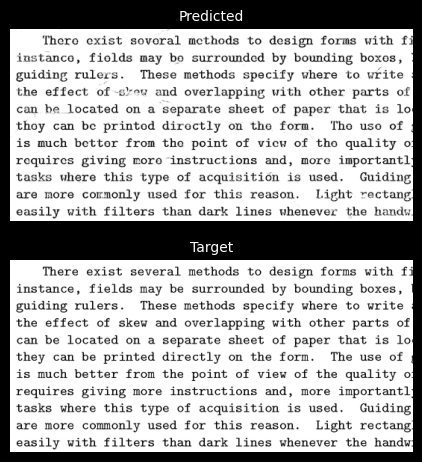

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5.5))
font = {"fontsize": 10, "color": "white"}

axes[0].imshow(cleaned, "gray")
axes[0].set_title("Predicted", font)
axes[0].set_axis_off()

axes[1].imshow(Ytest_img, "gray")
axes[1].set_title("Target", font)
axes[1].set_axis_off()

fig.set_facecolor("black")